[LightGBM] [Info] Number of positive: 378, number of negative: 422
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472500 -> initscore=-0.110111
[LightGBM] [Info] Start training from score -0.110111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 302, number of negative: 338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471875 -> initscore=-0.112619
[LightGBM] [Info] Start training from score -0.112619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:29:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.8550
📈 Precision: 0.9583
📉 Recall: 0.7263
🎯 F1 Score: 0.8263
🧠 R² Score: 0.4185
🚦 ROC-AUC Score: 0.9302

🔍 Classification Report:
               precision    recall  f1-score   support

      Low EI       0.80      0.97      0.88       105
     High EI       0.96      0.73      0.83        95

    accuracy                           0.85       200
   macro avg       0.88      0.85      0.85       200
weighted avg       0.87      0.85      0.85       200



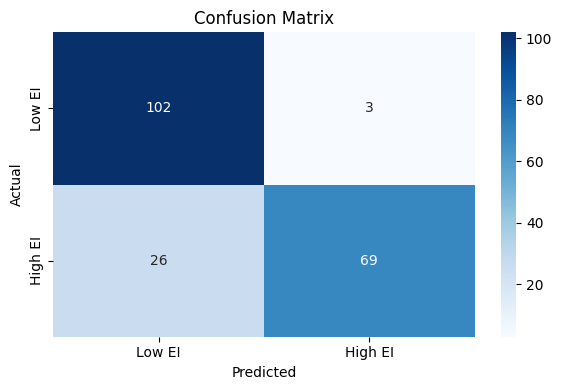

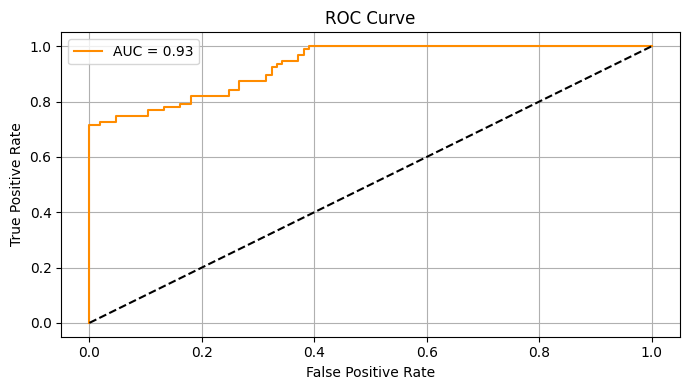

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

# --- Load Data ---
df = pd.read_csv("F:\\eduacatinalbot\\datasets\\AI_EI.csv")  # Update if needed

# --- Drop irrelevant ---
df.drop(columns=["Student_ID", "Simulated_Sentiment", "HERA_Recommendation"], errors='ignore', inplace=True)

# --- Clean column names ---
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# --- Handle missing ---
df.dropna(inplace=True)

# --- Encode categorical ---
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# --- Feature Engineering ---
if 'Satisfaction' in df.columns and 'Emotion_R' in df.columns:
    df["Satisfaction_Emotion"] = df["Satisfaction"] * df["Emotion_R"]
if 'Age' in df.columns and 'Academic_' in df.columns:
    df["Age_Academic"] = df["Age"] * df["Academic_"]

# --- Define features/target ---
if 'EI_Score' not in df.columns:
    raise KeyError("Column 'EI_Score' not found in dataset.")

X = df.drop(columns=["EI_Score"])
y_raw = df["EI_Score"]

# --- Target binarization via KMeans ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(y_raw.values.reshape(-1, 1))
y = pd.Series(clusters).map({kmeans.cluster_centers_.argmax(): 1, kmeans.cluster_centers_.argmin(): 0})

# --- Split and Scale ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Stacked Model ---
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=6, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=6, eval_metric='logloss', use_label_encoder=False, random_state=42))
]

stack = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)

# --- Train ---
stack.fit(X_train_scaled, y_train)

# --- Predict ---
y_pred = stack.predict(X_test_scaled)
y_proba = stack.predict_proba(X_test_scaled)[:, 1]

# --- Metrics ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"✅ Accuracy: {acc:.4f}")
print(f"📈 Precision: {prec:.4f}")
print(f"📉 Recall: {rec:.4f}")
print(f"🎯 F1 Score: {f1:.4f}")
print(f"🧠 R² Score: {r2:.4f}")
print(f"🚦 ROC-AUC Score: {roc_auc:.4f}\n")

print("🔍 Classification Report:\n", classification_report(y_test, y_pred, target_names=['Low EI', 'High EI']))

# --- Confusion Matrix ---
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Low EI', 'High EI'], yticklabels=['Low EI', 'High EI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Select a few rows from test set
sample_idx = np.random.choice(X_test.index, size=5, replace=False)
sample_data = X_test.loc[sample_idx]
sample_true = y_test.loc[sample_idx]

# Scale the sample
sample_scaled = scaler.transform(sample_data)

# Predict
sample_pred = stack.predict(sample_scaled)
sample_proba = stack.predict_proba(sample_scaled)[:, 1]

# Display
results_df = sample_data.copy()
results_df["True_Label"] = sample_true.values
results_df["Predicted_Label"] = sample_pred
results_df["Probability_High_EI"] = sample_proba

print("\n📊 Sample Predictions:")
print(results_df)



📊 Sample Predictions:
     Age  Gender  Academic_Performance  AI_Exposure_Level  \
103   28       1                  5.90                  0   
722   20       2                  8.83                  0   
478   23       2                  5.10                  2   
85    28       1                  8.63                  0   
110   23       1                  6.80                  2   

     Preferred_AI_Feature  Satisfaction_With_AI_Interaction  \
103                     0                                 2   
722                     0                                 1   
478                     3                                 1   
85                      3                                 4   
110                     3                                 1   

     Emotion_Recognition_By_AI_Accuracy_(%)  \
103                                   62.09   
722                                   72.90   
478                                   76.81   
85                                    73.91

In [4]:
import joblib

joblib.dump(stack, "ei_stack_model.pkl")
joblib.dump(scaler, "ei_scaler.pkl")

['ei_scaler.pkl']

In [5]:
# Later Load
model = joblib.load("ei_stack_model.pkl")
scaler = joblib.load("ei_scaler.pkl")